## Implementing RNN for seattle weather dataset (first dataset)
**Not the seattle airport dataset**
---

## Importing Libraries and loading the dataset
---

In [623]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, GRU, Bidirectional, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "seattle-weather.csv" 
data = pd.read_csv(file_path)
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


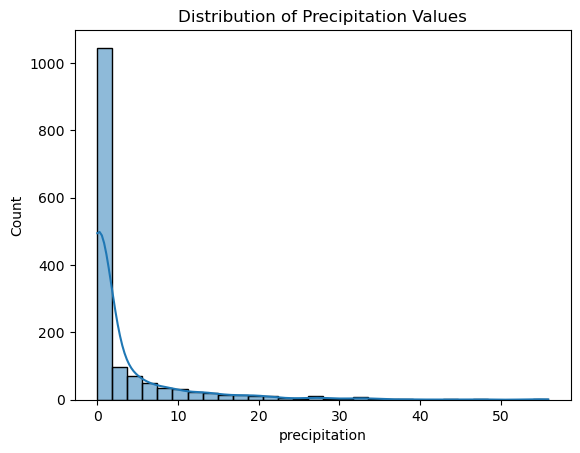

In [624]:
#Analyze data distribution
sns.histplot(data['precipitation'], bins=30, kde=True)
plt.title("Distribution of Precipitation Values")
plt.show()

**Very low amount of high precipitation values, imbalance in the dataset**
**Does reflect real world scenarios where high precipitation is rare in most locations**

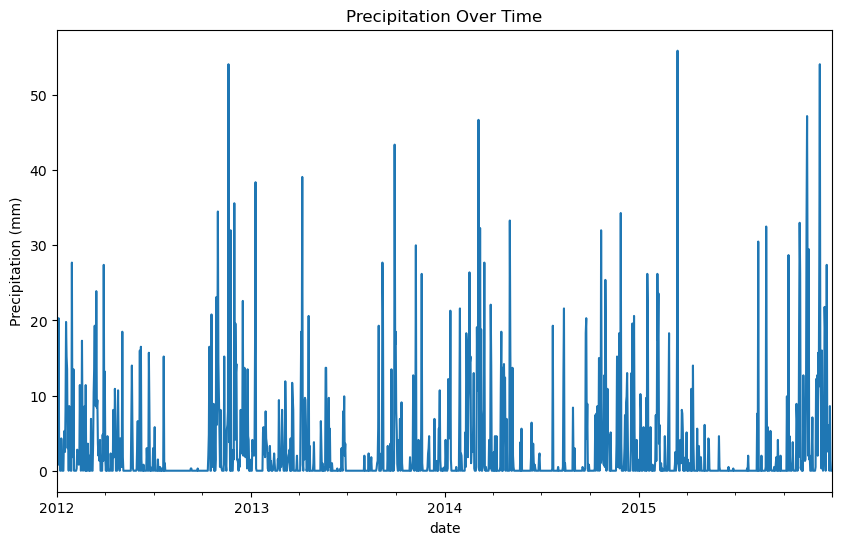

In [625]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

precip = data['precipitation']
precip.plot(title="Precipitation Over Time", ylabel="Precipitation (mm)", figsize=(10, 6))
plt.show()

**Overall precipitation seems to be skewed**

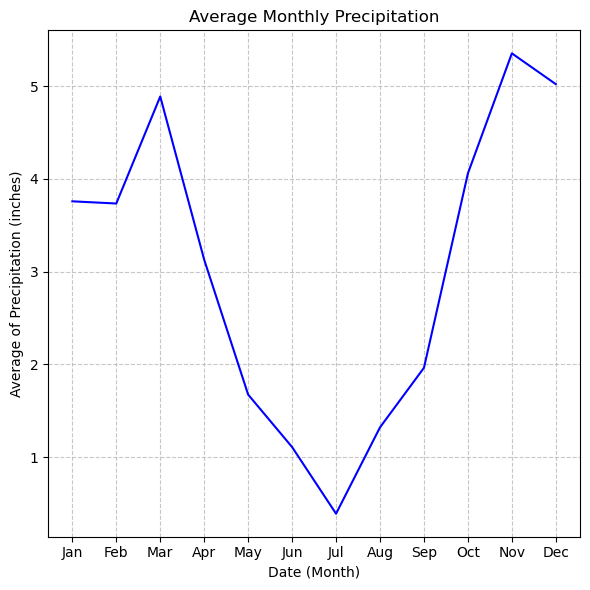

In [626]:
# Extract the month from the date index
data['month'] = data.index.month

# Calculate the monthly average precipitation
monthly_avg = data.groupby('month')['precipitation'].mean()

plt.figure(figsize=(6, 6))
plt.plot(monthly_avg.index, monthly_avg.values, linestyle='-', color='b')
plt.title("Average Monthly Precipitation")
plt.xlabel("Date (Month)")
plt.ylabel("Average of Precipitation (inches)")

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(monthly_avg.index, month_names)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Its likely seasonality and/or month are key strong features to engineer**

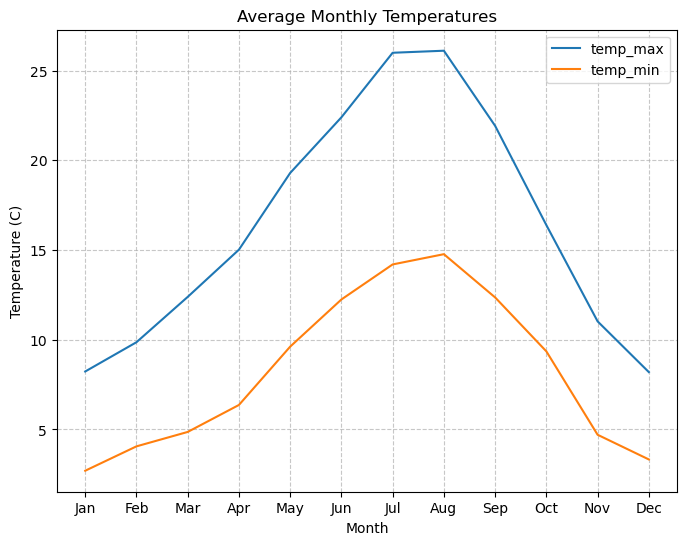

In [627]:
# Add 'month' column
data['month'] = data.index.month

# Group by month and calculate averages
monthly_avg_temp = data.groupby('month')[['temp_max', 'temp_min']].mean()

# Plot the monthly averages
monthly_avg_temp.plot(figsize=(8, 6), title="Average Monthly Temperatures")
plt.xlabel("Month")
plt.ylabel("Temperature (C)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**There is a clear seasonal temperature cycle, matches expected seasonal trends**

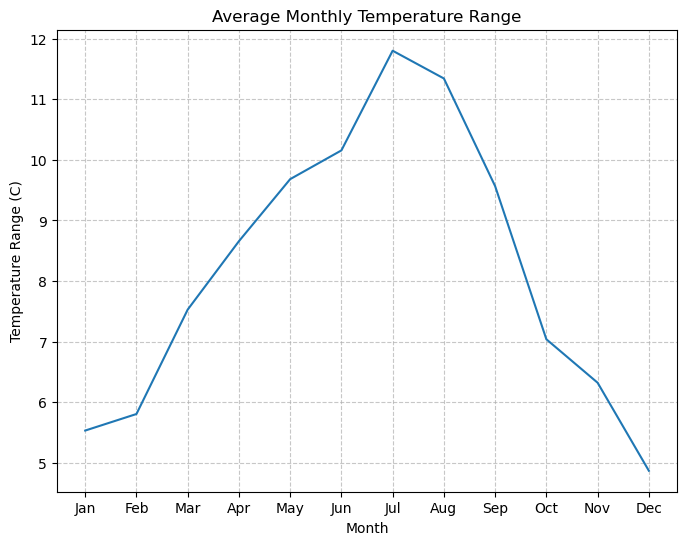

In [628]:
# Calcualte temp range
data['temp_range'] = data['temp_max'] - data['temp_min']
monthly_avg_temp_range = data.groupby('month')['temp_range'].mean()

# Plot monthly temperature range
monthly_avg_temp_range.plot(figsize=(8, 6), title="Average Monthly Temperature Range")
plt.xlabel("Month")
plt.ylabel("Temperature Range (C)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**Large temperature range in sumer season, and smaller range in winter season matches expected seasonal trends**

In [629]:
# basic function to return season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

data['season'] = data['month'].apply(get_season)

# Label encode season
data['season_encoded'] = LabelEncoder().fit_transform(data['season'])


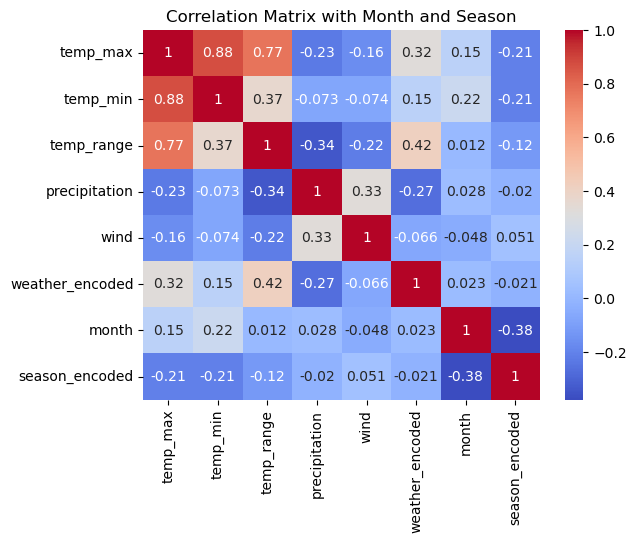

In [630]:
# Encoding weather
data['weather_encoded'] = LabelEncoder().fit_transform(data['weather'])
# Calculate correlation matrix
correlation = data[['temp_max', 'temp_min', 'temp_range', 'precipitation', 'wind', 'weather_encoded', 'month', 'season_encoded']].corr()

# Plot heatmap
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix with Month and Season")
plt.show()

In [631]:
# Features and target
features = ['temp_max', 'temp_min', 'month', 'weather_encoded', 'season_encoded', 'wind']
target = 'temp_range'

# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
data[target] = scaler.fit_transform(data[[target]])

# Prepare sequences for input for RNN
seq_length = 7  # Number of previous days to use
X, y = [], []

for i in range(len(data) - seq_length):
    X.append(data[features].iloc[i:i+seq_length].values)
    y.append(data['temp_range'].iloc[i+seq_length])

X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build sequential model
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32, activation='tanh', return_sequences=True),  # First RNN layer
    Dropout(0.3),
    SimpleRNN(16, activation='tanh', return_sequences=False),  # Second RNN layer
    Dropout(0.3),
    Dense(1)  # Output layer
])
print(rnn_model.summary())
# Compile model
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train 
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluation metrics
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_59 (SimpleRNN)            │ (None, 7, 32)               │           1,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_60 (SimpleRNN)            │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.4986 - mae: 0.5712 - val_loss: 0.0528 - val_mae: 0.1803
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3045 - mae: 0.4465 - val_loss: 0.0530 - val_mae: 0.1799
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2651 - mae: 0.4061 - val_loss: 0.0535 - val_mae: 0.1862
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1856 - mae: 0.3438 - val_loss: 0.0395 - val_mae: 0.1619
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1605 - mae: 0.3247 - val_loss: 0.0327 - val_mae: 0.1464
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1369 - mae: 0.2969 - val_loss: 0.0311 - val_mae: 0.1452
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1175 - mae: 0.2762 - val_loss: 0.0304 - val_mae: 0.1401
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0922 - mae: 0.2415 - val_loss: 0.0290 - val_mae: 0.1371
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

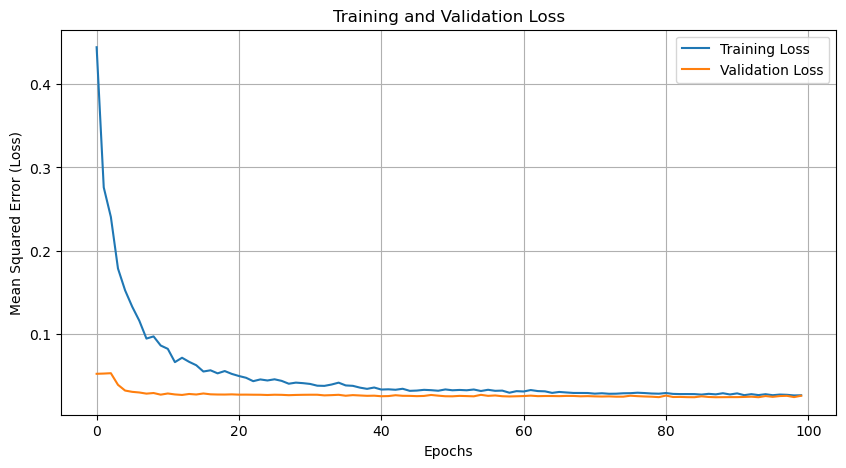

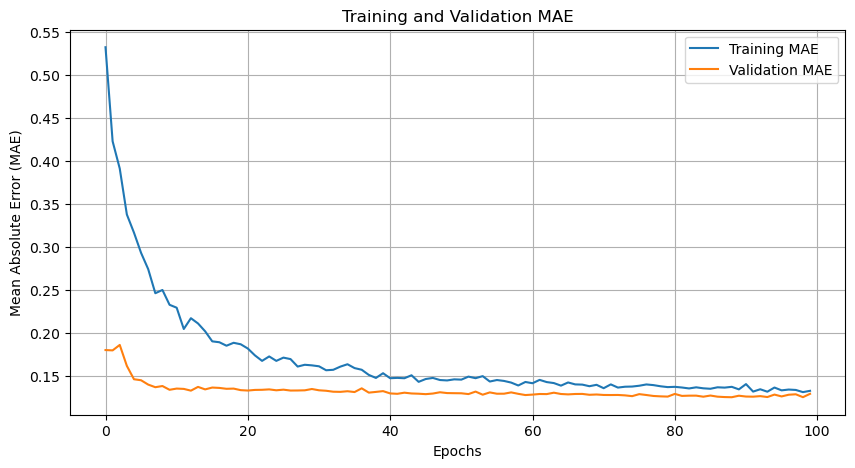

In [632]:
# Plotting MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

**Seems to generalize unseen data well, overfitting is not present**

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
   Actual Temp Range  Predicted Temp Range
0                7.7              9.289207
1               11.7             10.453625
2                3.9              5.189656
3                7.2              6.832917
4                6.1              5.899057


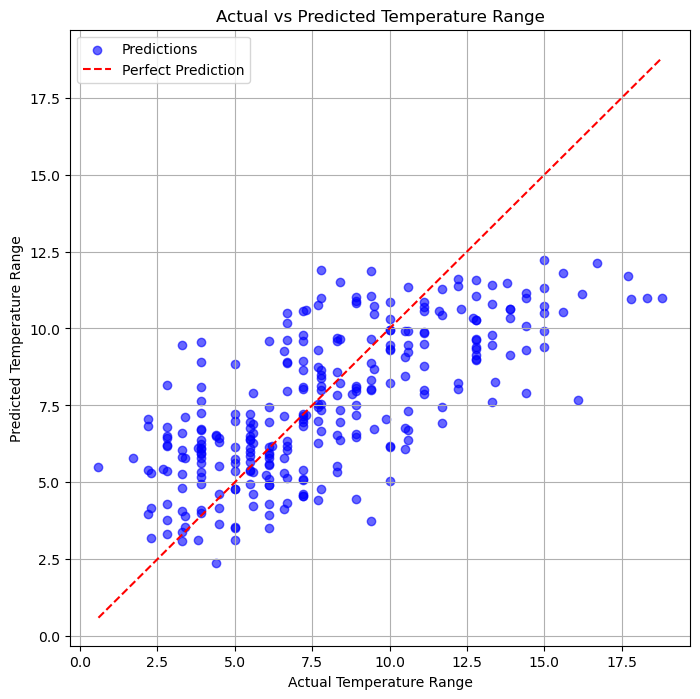

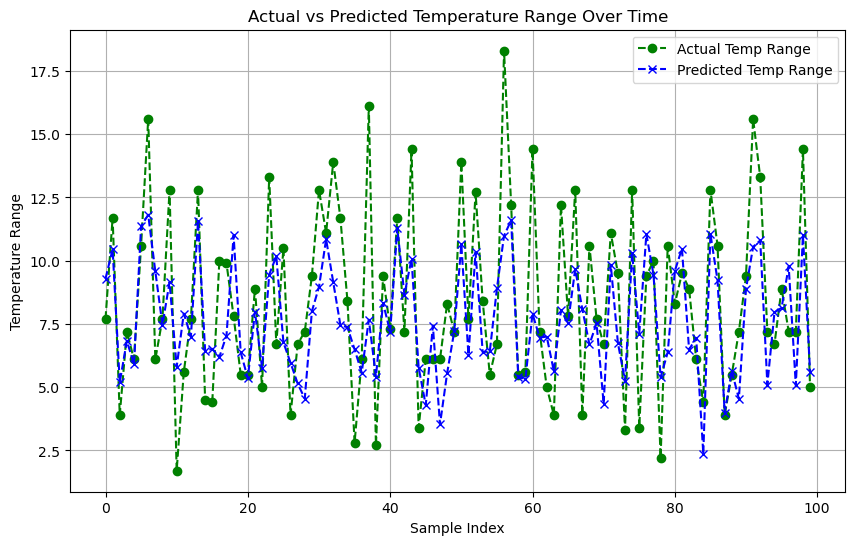

In [633]:
# Make predictions
predictions_scaled = rnn_model.predict(X_test).flatten()
# Rescale to original formats
predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create comparison data
comparison_df = pd.DataFrame({
    'Actual Temp Range': actuals,
    'Predicted Temp Range': predictions
})

# Display the first few rows of comparisons
print(comparison_df.head())

# Scatterplot
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.6, color="blue", label="Predictions")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color="red", linestyle="--", label="Perfect Prediction")
plt.title("Actual vs Predicted Temperature Range")
plt.xlabel("Actual Temperature Range")
plt.ylabel("Predicted Temperature Range")
plt.legend()
plt.grid(True)
plt.show()

# Comparison plot for first 100 points
plt.figure(figsize=(10, 6))
plt.plot(actuals[:100], label="Actual Temp Range", color="green", marker='o', linestyle='--')
plt.plot(predictions[:100], label="Predicted Temp Range", color="blue", marker='x', linestyle='--')
plt.title("Actual vs Predicted Temperature Range Over Time")
plt.xlabel("Sample Index")
plt.ylabel("Temperature Range")
plt.legend()
plt.grid(True)
plt.show()


**Has reasonable accuracy, predictions have slight deviations for most**
**It seems to be more inaccurate predicting larger temperatures, most likely due to imbalance in the dataset, but it does reflect real world scenarios for certain climates**